In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
nTI = 11
skip = 500

dvdl_ti = []
dvdl_ave = []
clambda = []

for ti in range(nTI):
    with open(f'd{ti:03d}/production.out', 'r') as file:
        captured_lambda = False
        
        for line in file:
            if "clambda" in line and not captured_lambda:
                clambda.append(float(line.split()[2].split(',')[0]))
                captured_lambda = True
                
            if "Summary of dvdl values over" in line:
                total_data = int(line.split()[-2])
                dvdl_i = np.zeros((int(total_data/skip) + 1))
                dvdl_a = np.zeros((int(total_data/skip) + 1))
                dvdl = 0.0
                j = 0
                for i in range(total_data):
                    if i % skip == 0:
                        data = float(file.readline())
                        dvdl += data
                        
                        dvdl_i[j] = data
                        dvdl_a[j] = dvdl / (j+1)
                        
                        j += 1
                        
                dvdl_ti.append(dvdl_i)
                dvdl_ave.append(dvdl_a)

clambda = np.array(clambda)
dvdl_ti = np.array(dvdl_ti)
dvdl_ave = np.array(dvdl_ave)

### Raw Data

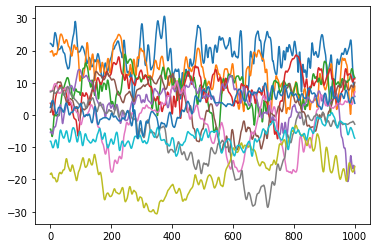

In [3]:
for i in range(11):
    plt.plot(dvdl_ti[i,:])
plt.xlabel('frames')
plt.ylabel('dvdl')

### Cumulative Average

Text(0, 0.5, '<dvdl>')

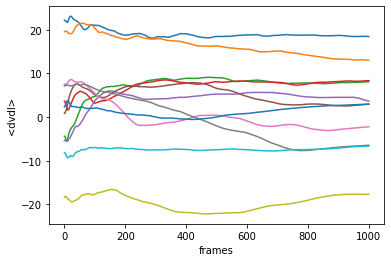

In [16]:
for i in range(11):
    plt.plot(dvdl_ave[i,:])
plt.xlabel('frames')
plt.ylabel('<dvdl>')

### DV/DL Average

Text(0, 0.5, '<dvdl>')

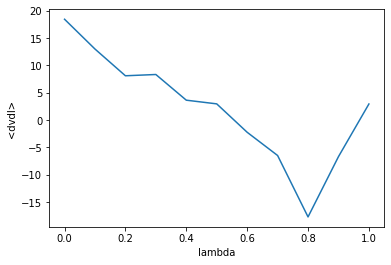

In [17]:
plt.plot(clambda, dvdl_ave[:,-1])
plt.xlabel('lambda')
plt.ylabel('<dvdl>')

### Cumulative Average of Integrand

Text(0, 0.5, 'v (kcal/mol)')

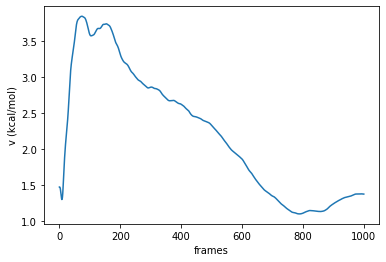

In [18]:
ndata = np.shape(dvdl_ti)[1]
TI = np.zeros(ndata)
for i in range(ndata):
    TI[i] = np.trapz(dvdl_ave[:,i], clambda)
    
plt.plot(TI)
plt.xlabel('frames')
plt.ylabel('v (kcal/mol)')